<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/data_cleanfeature_selection_400n_7hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
utkarshx27_american_companies_bankruptcy_prediction_dataset_path = kagglehub.dataset_download('utkarshx27/american-companies-bankruptcy-prediction-dataset')

print('Data source import complete.')


# Bankruptcy Feature Selection: 5-Method Importance Playbook

This notebook computes feature importance **using five complementary methods** to help you pick 5–7 attributes for classification:

1. Random Forest (built-in Gini/MDI)
2. Gradient Boosting (built-in importance)
3. Permutation Feature Importance (model-agnostic)
4. SHAP (TreeExplainer over a tree model)
5. Logistic Regression Coefficients (after scaling)

**Dataset**: `utkarshx27/american-companies-bankruptcy-prediction-dataset` via `kagglehub` (as requested).

Outputs:
- Per-method importance tables
- A combined ranking table (average rank & consensus)
- Simple matplotlib bar charts

> Tip: After you review the final combined ranking, pick your **Top 5–7 features** to train your classification model pipeline.

In [ ]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


## Load Dataset via `kagglehub`
The code below follows your given pattern. Update `file_path` to the CSV within the dataset if needed.

**Expected columns** (as provided):
- `company_name` (drop)  
- `status_label` (target)  
- `year` (1999–2018)  
- `X1 … X18` with meanings per your mapping


In [ ]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = None  # e.g., "american_bankruptcy.csv" if needed


# โหลด dataset จาก Kaggle input path
df = pd.read_csv("/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv")

# แสดงข้อมูล 5 แถวแรก
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## Basic Preprocessing
- Drop `company_name` (ID-like)
- Keep `year` as numeric (or one-hot encode later if needed)
- Define feature list (exclude `status_label`)
- Impute missing values (median)
- Split into train/test (stratified)


In [ ]:

FEATURES = ["X8","X17","X3","X11","X10","X1","X6"]
TARGET   = "status_label"
COMPANY  = "company_name"   # ถ้าไม่มีคอลัมน์นี้ โค้ดจะ fallback อัตโนมัติ

# ---------- helpers ----------
def _check_cols(df, features, target, company_col=None):
    req = set(features+[target])
    miss = list(req - set(df.columns))
    if miss:
        raise ValueError(f"Missing columns: {miss}")
    if company_col is not None and company_col not in df.columns:
        company_col = None
    return company_col

def _clip_like(df_aug, df_ref, features):
    # คลิปค่าให้อยู่ในช่วง min/max ของทั้ง dataset เพื่อไม่ให้ synthetic หลุดโลก
    mins = df_ref[features].min()
    maxs = df_ref[features].max()
    df_aug[features] = df_aug[features].clip(lower=mins, upper=maxs, axis=1)
    return df_aug

def augment_failed(df, features=FEATURES, target=TARGET, company_col=COMPANY,
                   n_new=0, random_state=42):
    """สร้างแถว failed (target=1) เพิ่ม n_new แถว ด้วย 3 วิธี: uniform jitter, gaussian noise, mixup."""
    if n_new <= 0:
        return pd.DataFrame(columns=df.columns)

    rng = np.random.default_rng(random_state)
    df1 = df[df[target]==1].copy()
    if df1.empty:
        raise ValueError("No failed rows to augment.")

    # เตรียมสัดส่วน 3 วิธี แบ่งพอๆ กัน
    n1 = int(np.floor(n_new/3))
    n2 = int(np.floor(n_new/3))
    n3 = n_new - n1 - n2

    # 1) Uniform jitter ±0.5%
    take1 = df1.sample(n=max(n1,0), replace=True, random_state=random_state).copy()
    if not take1.empty:
        jitter = rng.uniform(-0.005, 0.005, size=(len(take1), len(features)))
        take1.loc[:, features] = take1[features].values * (1.0 + jitter)
        take1["aug_method"] = "uniform_0p5pct"

    # 2) Gaussian noise (σ = 0.5% ของ std ต่อคอลัมน์คลาส failed)
    take2 = df1.sample(n=max(n2,0), replace=True, random_state=random_state+1).copy()
    if not take2.empty:
        stds = df1[features].std().replace(0, 1e-12)
        noise = rng.normal(loc=0.0, scale=(0.005*stds.values), size=(len(take2), len(features)))
        take2.loc[:, features] = take2[features].values + noise
        take2["aug_method"] = "gaussian_0p5pct_std"

    # 3) Mixup (λ ~ Beta(0.4, 0.4))
    take3 = pd.DataFrame(columns=df.columns)
    if n3 > 0:
        a = df1.sample(n=n3, replace=True, random_state=random_state+2)
        b = df1.sample(n=n3, replace=True, random_state=random_state+3)
        lam = rng.beta(0.4, 0.4, size=n3).reshape(-1,1)
        mix_vals = lam * a[features].values + (1-lam) * b[features].values
        take3 = a.copy()
        take3.loc[:, features] = mix_vals
        take3["aug_method"] = "mixup_beta_0.4"

    df_aug = pd.concat([x for x in [take1, take2, take3] if not x.empty], ignore_index=True)
    df_aug[target] = 1

    # ทำให้ค่ามีเหตุผล (clip ตาม min/max ทั้ง df)
    df_aug = _clip_like(df_aug, df, features)

    # ถ้าอยากตั้งชื่อบริษัทให้รู้ว่าเป็น aug (เฉพาะมี company_name)
    if company_col is not None:
        df_aug[company_col] = df_aug[company_col].astype(str)  # คงบริษัทเดิมไว้ (สมจริงกว่า)
        # หรือจะเติม suffix:
        # df_aug[company_col] = df_aug[company_col].astype(str) + "_aug"

    return df_aug

def downsample_alive_diverse(df, keep_n, features=FEATURES, target=TARGET, company_col=COMPANY, random_state=42):
    """คัด 'alive'=0 ให้เหลือ keep_n โดยกระจาย 'บริษัท' ให้หลากหลายที่สุดเท่าที่ทำได้"""
    df0 = df[df[target]==0].copy()
    if company_col is None:
        # ไม่มี company_name → สุ่มตรงๆ
        return df0.sample(n=min(keep_n, len(df0)), replace=False, random_state=rs)

    rs = np.random.RandomState(random_state)

    # 1) เลือกอย่างน้อย 1 แถวต่่อบริษัท (ครอบคลุมบริษัทให้เยอะสุด)
    pick1 = df0.groupby(company_col, group_keys=False).apply(lambda g: g.sample(1, random_state=rs)).reset_index(drop=True)
    if len(pick1) >= keep_n:
        # บริษัทเยอะกว่าโควต้า → สุ่มเลือกบริษัทบางส่วน
        # เลือกบริษัทสุ่ม keep_n แห่ง แล้วหยิบ 1 แถวจากแต่ละบริษัท
        chosen_companies = rs.choice(pick1[company_col].unique(), size=keep_n, replace=False)
        kept = pick1[pick1[company_col].isin(chosen_companies)].copy()
        return kept.reset_index(drop=True)

    # 2) ถ้ายังไม่พอ ต้องเติมจากแถวนอกเหนือจากที่เลือกไปแล้ว
    rem_need = keep_n - len(pick1)
    remaining = df0.drop(index=pick1.index)
    if rem_need > len(remaining):
        rem_need = len(remaining)
    pick2 = remaining.sample(n=rem_need, replace=False, random_state=rs)
    kept = pd.concat([pick1, pick2], ignore_index=True)
    return kept.sample(frac=1.0, random_state=rs).reset_index(drop=True)

def balance_40_50(df, features=FEATURES, target=TARGET, company_col=COMPANY,
                  target_ratio=0.45, min_ratio=0.40, random_state=42):
    """
    ทำให้สัดส่วน failed อยู่ในช่วง ~40–50%.
    กลยุทธ์:
      1) คำนวณเพดานจำนวน alive ที่ 'ควรเก็บ' เพื่อให้ >= min_ratio โดยไม่ต้อง augment: N_new <= P*(1-min)/min
      2) downsample alive โดยกระจายบริษัท
      3) augment failed เพิ่มให้ถึง target_ratio ด้วย 3 วิธี noise
    """
    company_col = _check_cols(df, features, target, company_col)

    df = df.copy()
    df[target] = df[target].astype(int)

    P = int((df[target]==1).sum())
    N = int((df[target]==0).sum())

    if P == 0:
        raise ValueError("No failed rows in the dataset.")
    if N == 0:
        return df  # already all failed

    # 1) หาโควต้าจำนวน alive สูงสุดที่ยังทำให้ ratio >= min_ratio ถ้าไม่ augment
    #    เงื่อนไข: P / (P + N_keep) >= min_ratio  ->  N_keep <= P*(1-min)/min
    N_keep_cap = int(np.floor(P*(1 - min_ratio) / min_ratio))
    N_keep_cap = max(1, min(N_keep_cap, N))  # ป้องกันขอบ
    # เลือกจำนวน alive ที่เราจะ "เก็บ" จริง ๆ (อาจเท่ากับ cap)
    N_keep = N_keep_cap

    # 2) คัด alive ให้เหลือ N_keep โดยกระจายบริษัท
    kept_alive = downsample_alive_diverse(df, keep_n=N_keep, features=features, target=target,
                                          company_col=company_col, random_state=random_state)

    # 3) จำนวน failed ที่ "ต้องมี" เพื่อได้ target_ratio:
    #    r = (P + A) / (P + A + N_keep) = target_ratio  ->  A = r*N_keep/(1-r) - P
    A_need = int(np.ceil(target_ratio * N_keep / (1 - target_ratio) - P))
    A_need = max(0, A_need)

    df_failed = df[df[target]==1]
    df_aug = augment_failed(
        pd.concat([df_failed, kept_alive], ignore_index=True),  # ให้ clip ช่วงตามทั้งชุดใหม่
        features=features, target=target, company_col=company_col,
        n_new=A_need, random_state=random_state
    )

    # รวมชุดใหม่: failed เดิม + failed augment + alive ที่คัดไว้
    new_df = pd.concat([df_failed, df_aug, kept_alive], ignore_index=True)
    new_df = new_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # รายงานผล
    P2 = int((new_df[target]==1).sum()); N2 = int((new_df[target]==0).sum())
    ratio = P2 / (P2 + N2)
    print(f"Before: failed={P}, alive={N}, ratio={P/(P+N):.3f}")
    print(f"Keep alive = {N_keep}  |  Aug failed = {A_need}")
    print(f"After:  failed={P2}, alive={N2}, ratio={ratio:.3f}  (~{ratio*100:.1f}%)")
    if company_col is not None:
        uniq_alive = new_df.loc[new_df[target]==0, company_col].nunique()
        print(f"Unique companies among KEPT alive: {uniq_alive}")
    return new_df

In [ ]:

# 0) ตรวจว่าคอลัมน์ครบไหม
missing = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns: {missing}")

# 1) ฟังก์ชัน normalize label ให้เป็น 0/1 แบบทนทาน
def normalize_status(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    # ตัวเลขที่มาเป็นสตริง หรือ float 0.0/1.0
    if t in {"0","1"}:
        return int(t)
    try:
        # กรณีเป็น 0.0/1.0 จริง ๆ
        f = float(t)
        if f in (0.0, 1.0):
            return int(f)
    except:
        pass
    # แม็พคำยอดฮิต
    direct = {
        "alive": 0, "non-bankrupt": 0, "nonbankrupt": 0, "healthy": 0, "normal": 0,
        "failed": 1, "fail": 1, "bankrupt": 1, "bankruptcy": 1, "went_bankrupt": 1,
        "yes": 1, "y": 1, "true": 1,
        "no": 0, "n": 0, "false": 0
    }
    if t in direct:
        return direct[t]
    # สุดท้าย ถ้าระบุไม่ถูก ให้คืน NaN เพื่อตรวจสอบ
    return np.nan

y_norm = df[TARGET].apply(normalize_status)

# 2) เช็คค่าที่แปลงไม่ได้ (จะเป็น NaN)
bad_mask = y_norm.isna()
if bad_mask.any():
    print("⚠️ พบ label ที่ไม่รู้จัก (ตัวอย่าง top 20):")
    print(df.loc[bad_mask, TARGET].value_counts().head(20))
    # ทางเลือก: ตัดแถวที่ label ไม่ชัดเจนทิ้งไปก่อน
    df = df.loc[~bad_mask].copy()
    y_norm = y_norm.loc[~bad_mask]

# 3) เขียนกลับเป็นตัวเลข 0/1
df[TARGET] = y_norm.astype(int)


balanced = balance_40_50(
    df=df,
    features=["X8","X17","X3","X11","X10","X1","X6"],
    target="status_label",
    company_col="company_name",   # ถ้าไม่มีคอลัมน์นี้ ปล่อยไว้หรือส่ง None
    target_ratio=0.5,            # ปรับเป็น 0.50 หากอยาก 50/50
    min_ratio=0.40,
    random_state=42
)

Before: failed=5220, alive=73462, ratio=0.066
Keep alive = 7830  |  Aug failed = 2610
After:  failed=7830, alive=7830, ratio=0.500  (~50.0%)
Unique companies among KEPT alive: 7830


In [ ]:
df = balanced.copy()
df.tail(22)

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,aug_method
15638,C_716,0,2016,120.919000,364.645,20.875000,59.567,51.249,22.555000,58.571,...,418.584000,94.626000,38.692,118.948,55.672,166.195,483.593,200.756000,424.026,NaN
15639,C_3837,0,2017,353.265000,168.726,18.764000,-60.660,0.000,-63.708000,43.113,...,449.782000,0.000000,-79.424,230.294,78.527,-248.413,399.020,89.936000,459.680,NaN
15640,C_1020,1,2000,156.740000,393.287,17.768000,46.516,8.046,19.784000,35.771,...,223.734000,2.172000,28.748,46.516,46.566,114.872,439.803,59.053000,393.287,NaN
15641,C_2240,1,2004,203.763000,622.423,66.532000,335.841,17.032,155.876000,142.202,...,2049.400000,267.200000,269.309,540.953,156.890,1087.050,1163.376,626.396000,827.535,NaN
15642,C_1521,0,2004,22.539000,18.523,2.362000,3.070,7.857,-0.420000,7.709,...,43.549000,0.000000,0.708,25.859,7.121,-3.897,44.382,7.121000,41.312,NaN
15643,C_4375,0,2017,18.376000,105.472,1.863000,0.479,10.906,-0.791000,4.903,...,48.942000,16.043000,-1.384,31.217,21.036,-3.964,136.689,43.477000,136.210,NaN
15644,C_4636,0,2018,4.928000,7.864,0.355000,-13.459,0.000,-18.750000,0.296,...,5.630000,0.000000,-13.814,-1.786,2.592,-29.754,6.078,2.592000,19.537,NaN
15645,C_4911,0,2001,0.634000,0.202,0.020000,-0.480,0.080,-1.702000,0.052,...,1.882000,2.352000,-0.500,0.152,1.895,-17.748,0.354,4.322000,0.834,NaN
15646,C_7807,0,2009,39.034000,40.937,2.547000,3.785,0.000,-1.085000,15.986,...,69.170000,0.057000,1.238,19.400,18.081,-2.860,60.337,21.866000,56.552,NaN
15647,C_2293,1,2002,76.580507,173.123,3.843245,14.451,34.511,0.855731,33.814,...,131.164926,32.460131,10.609,47.143,48.169,8.826,220.266,85.915872,205.815,uniform_0p5pct


In [ ]:
# Drop obvious non-feature column(s)
df_proc = df.copy()
if 'company_name' in df_proc.columns:
    df_proc = df_proc.drop(columns=['company_name'])
if 'aug_method' in df_proc.columns:
    df_proc = df_proc.drop(columns=['aug_method'])

target_col = 'status_label'
assert target_col in df_proc.columns, "status_label (target) not found!"

# Identify feature columns (all except target)
feature_cols = [c for c in df_proc.columns if c != target_col]

# Train/Test Split
X = df_proc[feature_cols]
y = df_proc[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Numeric pipeline: impute median (you can add scaler per-model later)
numeric_features = feature_cols
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder='drop'
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (11745, 19)  Test shape: (3915, 19)


## 1) Random Forest Importance

In [ ]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ))
])
rf_pipe.fit(X_train, y_train)
rf = rf_pipe.named_steps['rf']

# Extract fitted features order from ColumnTransformer
feat_names = numeric_features
rf_importance = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print(rf_importance.head(10))
rf_importance_df = rf_importance.reset_index()
rf_importance_df.columns = ['feature', 'rf_importance']
rf_importance_df.head()

year    0.092328
X8      0.065041
X11     0.059427
X15     0.059391
X17     0.057496
X6      0.056729
X7      0.053219
X1      0.052229
X3      0.051439
X13     0.049777
dtype: float64


,feature,rf_importance
0,year,0.092328
1,X8,0.065041
2,X11,0.059427
3,X15,0.059391
4,X17,0.057496


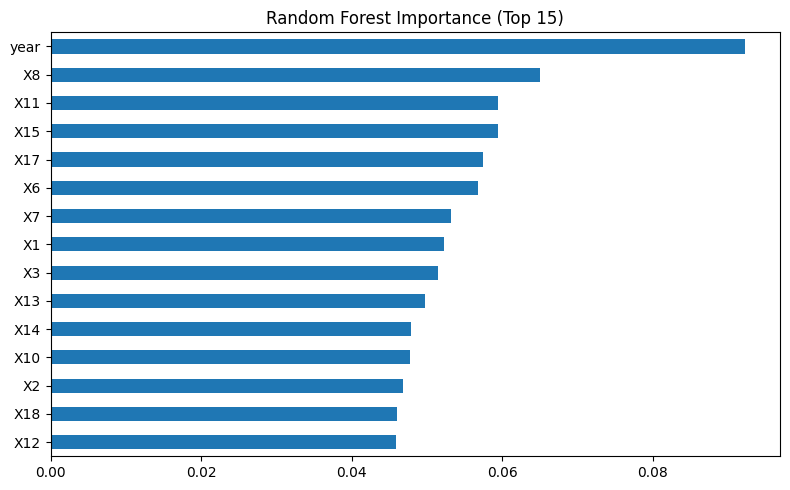

In [ ]:
# Plot RF importances
plt.figure(figsize=(8,5))
rf_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Random Forest Importance (Top 15)')
plt.tight_layout()
plt.show()

## 2) Gradient Boosting Importance (sklearn GBDT)
*(You can switch to XGBoost/LightGBM if preferred — both also expose built-in importance like `gain`.)*

In [ ]:
gb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("gb", GradientBoostingClassifier(random_state=42))
])
gb_pipe.fit(X_train, y_train)
gb = gb_pipe.named_steps['gb']
gb_importance = pd.Series(gb.feature_importances_, index=feat_names).sort_values(ascending=False)
print(gb_importance.head(10))
gb_importance_df = gb_importance.reset_index(); gb_importance_df.columns = ['feature','gb_importance']
gb_importance_df.head()

year    0.263193
X11     0.122370
X8      0.110783
X6      0.104427
X15     0.046829
X17     0.045966
X7      0.042395
X3      0.039985
X18     0.033411
X1      0.032880
dtype: float64


,feature,gb_importance
0,year,0.263193
1,X11,0.122370
2,X8,0.110783
3,X6,0.104427
4,X15,0.046829


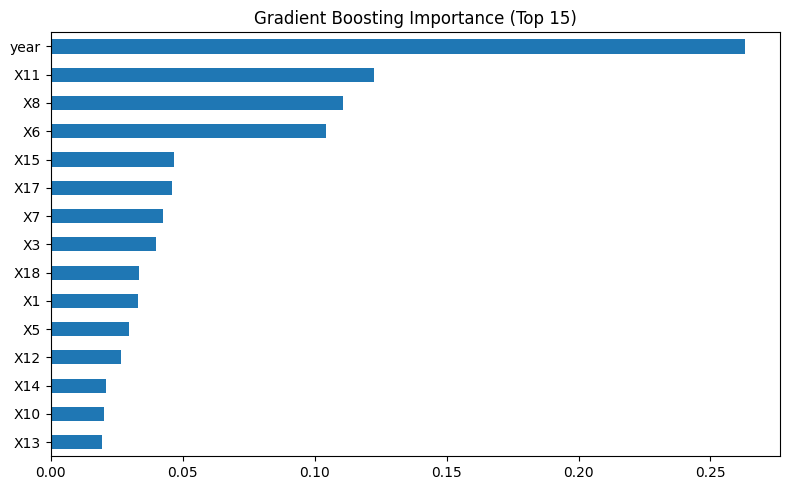

In [ ]:
plt.figure(figsize=(8,5))
gb_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Gradient Boosting Importance (Top 15)')
plt.tight_layout()
plt.show()

## 3) Permutation Feature Importance (model-agnostic on RF model)
Runs on the **validation** set to estimate performance drop when shuffling each feature.

In [ ]:
rf_pipe_score = rf_pipe.score(X_test, y_test)
perm = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_scores = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("Base RF score:", rf_pipe_score)
print(perm_scores.head(10))
perm_df = perm_scores.reset_index(); perm_df.columns = ['feature','perm_importance']
perm_df.head()

Base RF score: 0.8033205619412516
year    0.091826
X11     0.049732
X8      0.030013
X15     0.026105
X17     0.025006
X7      0.017471
X5      0.015172
X3      0.011341
X6      0.010319
X1      0.007969
dtype: float64


,feature,perm_importance
0,year,0.091826
1,X11,0.049732
2,X8,0.030013
3,X15,0.026105
4,X17,0.025006


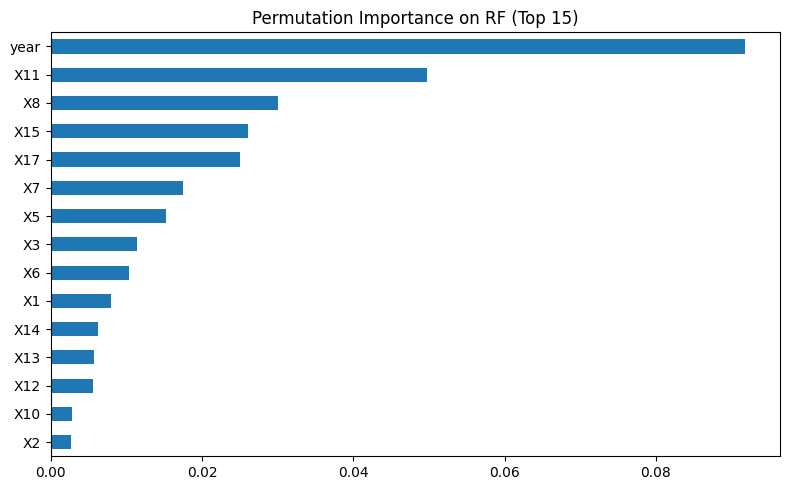

In [ ]:
plt.figure(figsize=(8,5))
perm_scores.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance on RF (Top 15)')
plt.tight_layout()
plt.show()

## 4) SHAP (TreeExplainer on RF)
We take **mean absolute SHAP value** per feature on the validation set as global importance.

In [ ]:
# Build a fresh RF (fitted) object on imputed data to pass raw arrays to SHAP
X_train_imp = preprocess.fit_transform(X_train)
X_test_imp = preprocess.transform(X_test)
rf_shap = RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42, n_jobs=-1)
rf_shap.fit(X_train_imp, y_train)

explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_imp)
if isinstance(shap_values, list):
    # For binary classification, take class 1 contributions
    sv = shap_values[1]
else:
    sv = shap_values

shap_abs_mean = np.abs(sv).mean(axis=0)
shap_importance = pd.Series(shap_abs_mean, index=feat_names).sort_values(ascending=False)
print(shap_importance.head(10))
shap_df = shap_importance.reset_index(); shap_df.columns = ['feature','shap_importance']
shap_df.head()

year    0.068819
X11     0.046582
X8      0.027694
X17     0.027452
X6      0.022143
X15     0.019214
X7      0.017428
X5      0.016741
X1      0.016431
X3      0.013907
dtype: float64


,feature,shap_importance
0,year,0.068819
1,X11,0.046582
2,X8,0.027694
3,X17,0.027452
4,X6,0.022143


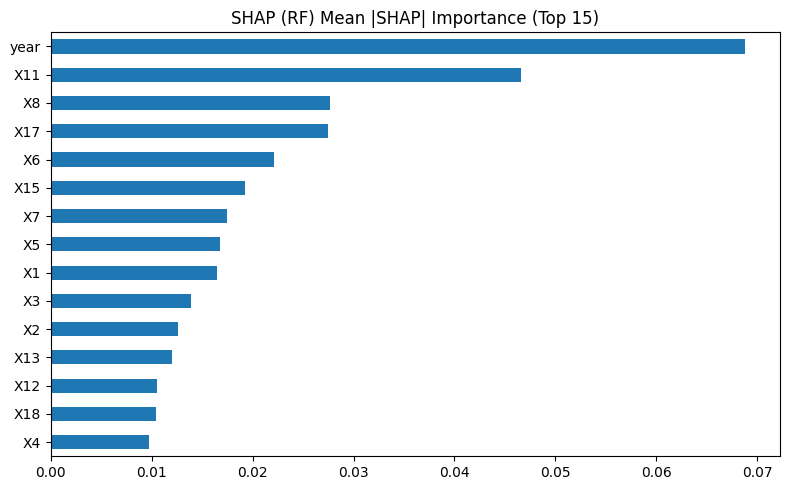

In [ ]:
plt.figure(figsize=(8,5))
shap_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('SHAP (RF) Mean |SHAP| Importance (Top 15)')
plt.tight_layout()
plt.show()

## 5) Logistic Regression Coefficients (after scaling)
We use absolute coefficient magnitude as global importance.
- Pipeline: Impute → Scale → LogisticRegression
- For binary target, take `abs(coef_)`. If OvR, average abs across classes.

In [ ]:
logit_pipe = Pipeline(steps=[
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
    ], remainder='drop')),
    ("logit", LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')),
])
logit_pipe.fit(X_train, y_train)
logit = logit_pipe.named_steps['logit']

coefs = logit.coef_
if coefs.ndim == 1:
    coef_abs = np.abs(coefs)
else:
    coef_abs = np.mean(np.abs(coefs), axis=0)
logit_importance = pd.Series(coef_abs, index=feat_names).sort_values(ascending=False)
print(logit_importance.head(10))
logit_df = logit_importance.reset_index(); logit_df.columns = ['feature','logit_importance']
logit_df.head()

X8      0.963495
X1      0.515348
X17     0.408509
X5      0.344610
X3      0.269330
X11     0.234115
X10     0.203224
year    0.191855
X14     0.151888
X12     0.101299
dtype: float64


,feature,logit_importance
0,X8,0.963495
1,X1,0.515348
2,X17,0.408509
3,X5,0.344610
4,X3,0.269330


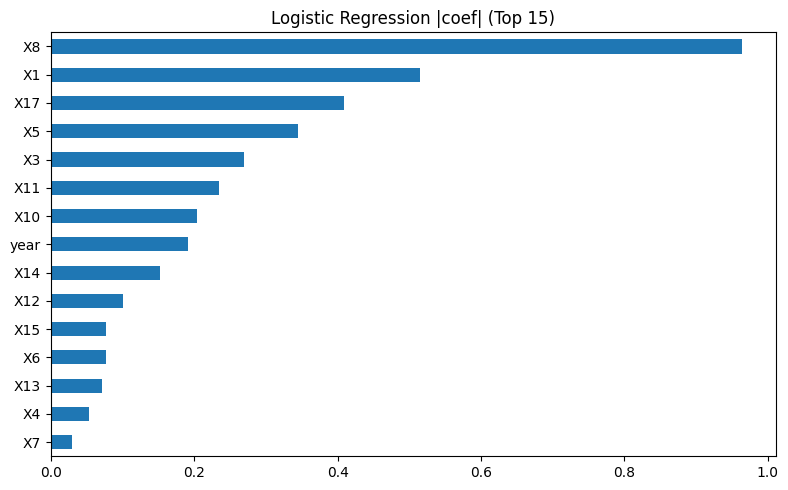

In [ ]:
plt.figure(figsize=(8,5))
logit_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Logistic Regression |coef| (Top 15)')
plt.tight_layout()
plt.show()

## Combine Rankings
We convert each method’s importances into ranks (1 = most important), then compute **average rank** and **consensus count** (how many methods put the feature in Top-k).

In [ ]:
dfs = [rf_importance_df, gb_importance_df, perm_df, shap_df, logit_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

,feature,rf_importance,gb_importance,perm_importance,shap_importance,logit_importance,rf_importance_rank,gb_importance_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
18,year,0.092328,0.263193,0.091826,0.068819,0.191855,1.0,1.0,1.0,1.0,8.0,2.4
16,X8,0.065041,0.110783,0.030013,0.027694,0.963495,2.0,3.0,3.0,3.0,1.0,2.4
2,X11,0.059427,0.122370,0.049732,0.046582,0.234115,3.0,2.0,2.0,2.0,6.0,3.0
8,X17,0.057496,0.045966,0.025006,0.027452,0.408509,5.0,6.0,5.0,4.0,3.0,4.6
6,X15,0.059391,0.046829,0.026105,0.019214,0.077511,4.0,5.0,4.0,6.0,11.0,6.0
14,X6,0.056729,0.104427,0.010319,0.022143,0.077407,6.0,4.0,9.0,5.0,12.0,7.2
0,X1,0.052229,0.032880,0.007969,0.016431,0.515348,8.0,10.0,10.0,9.0,2.0,7.8
11,X3,0.051439,0.039985,0.011341,0.013907,0.269330,9.0,8.0,8.0,10.0,5.0,8.0
15,X7,0.053219,0.042395,0.017471,0.017428,0.029925,7.0,7.0,6.0,7.0,15.0,8.4
13,X5,0.044394,0.029605,0.015172,0.016741,0.344610,17.0,11.0,7.0,8.0,4.0,9.4


Top-7 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
18,year,2.4,1.0,1.0,1.0,1.0,8.0,2.4
16,X8,2.4,2.0,3.0,3.0,3.0,1.0,2.4
2,X11,3.0,3.0,2.0,2.0,2.0,6.0,3.0
8,X17,4.6,5.0,6.0,5.0,4.0,3.0,4.6
6,X15,6.0,4.0,5.0,4.0,6.0,11.0,6.0
14,X6,7.2,6.0,4.0,9.0,5.0,12.0,7.2
0,X1,7.8,8.0,10.0,10.0,9.0,2.0,7.8


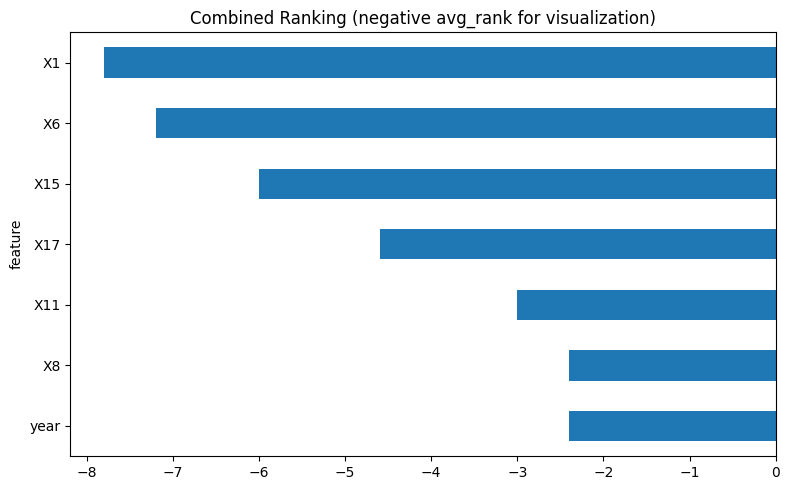

In [ ]:
from math import ceil
TOP_K = 7
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

In [ ]:
dfs = [perm_df, shap_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

NameError: name 'perm_df' is not defined

Top-7 features by average rank:


,feature,avg_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
16,X8,2.333333,3.0,3.0,1.0,2.333333
2,X11,3.333333,2.0,2.0,6.0,3.333333
18,year,3.333333,1.0,1.0,8.0,3.333333
8,X17,4.000000,5.0,4.0,3.0,4.000000
13,X5,6.333333,7.0,8.0,4.0,6.333333
0,X1,7.000000,10.0,9.0,2.0,7.000000
6,X15,7.000000,4.0,6.0,11.0,7.000000


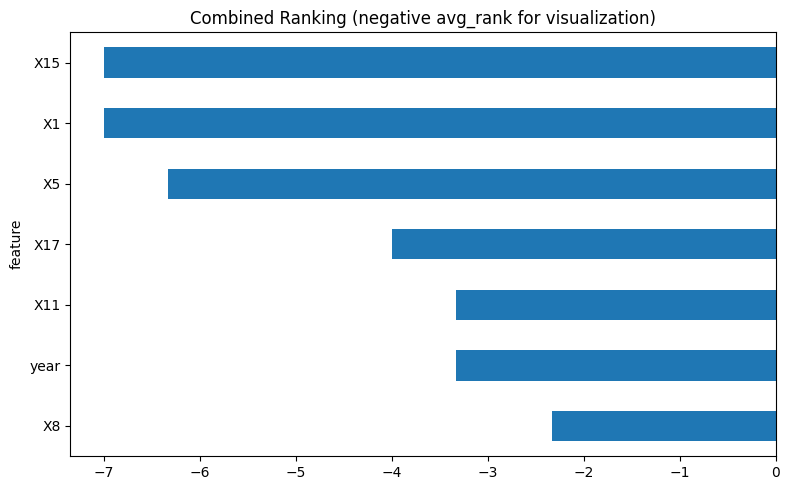

In [ ]:
from math import ceil
TOP_K = 7
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

### Notes
- You can **swap GradientBoostingClassifier** for **XGBoost/LightGBM** and use their `feature_importances_` or Booster importance types (`gain`, `cover`).
- For **Permutation** and **SHAP**, you can run them on any trained model; here we used RF to keep runtime reasonable.
- After deciding your **Top 5–7 features**, re-train your classification model and report metrics: Accuracy, Precision/Recall, F1, ROC-AUC, Confusion Matrix, etc.